In [1]:
import numpy as np
from scipy.optimize import fsolve, basinhopping
import random
import timeit

In [2]:
from xgboost import XGBClassifier

In [3]:
XGBClassifier??

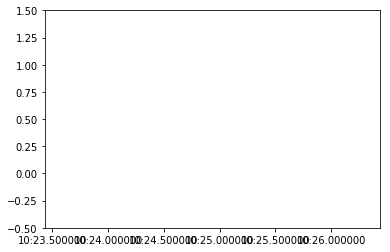

In [12]:
from datetime import datetime, timedelta
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Create new plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Create rectangle x coordinates
# startTime = datetime.now()
# endTime = startTime + timedelta(seconds = 1)

# convert to matplotlib date representation
start = mdates.date2num(startTime)
end = mdates.date2num(endTime)
width = end - start

# Plot rectangle
rect = Rectangle((1, 0), 3, 1, color='yellow')
ax.add_patch(rect)   

# assign date locator / formatter to the x-axis to get proper labels
locator = mdates.AutoDateLocator(minticks=3)
formatter = mdates.AutoDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

# set the limits
plt.xlim([start-width, end+width])
plt.ylim([-.5, 1.5])

# go
plt.show()

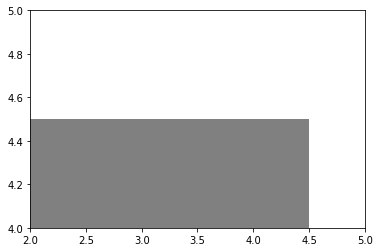

In [20]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
someX, someY = 2 ,4
width = 3
height = 1
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((someX - .5, someY - .5), width, height, facecolor="grey"))
# set the limits
plt.xlim([someX, someX+width])
plt.ylim([someY, someY + height])
plt.show()

In [15]:
end+width

736931.4239054822

In [ ]:
def main(max_iter=500):
    # 每次迭代得到的最优解
    optimalSolutions = []
    optimalValues = []
    # 决策变量的取值范围
    decisionVariables = [[-3.0, 12.1], [4.1, 5.8]]
    # 得到染色体编码长度
    lengthEncode = getEncodedLength(boundarylist=decisionVariables)
    for iteration in range(max_iter):
        # 得到初始种群编码
        chromosomesEncoded = getIntialPopulation(lengthEncode, 10)
        # 种群解码
        decoded = decodedChromosome(lengthEncode, chromosomesEncoded, decisionVariables)
        # 得到个体适应度值和个体的累积概率
        evalvalues, cum_proba = getFitnessValue(fitnessFunction(), decoded)
        # 选择新的种群
        newpopulations = selectNewPopulation(chromosomesEncoded, cum_proba)
        # 进行交叉操作
        crossoverpopulation = crossover(newpopulations)
        # mutation
        mutationpopulation = mutation(crossoverpopulation)
        # 将变异后的种群解码，得到每轮迭代最终的种群
        final_decoded = decodedChromosome(lengthEncode, mutationpopulation, decisionVariables)
        # 适应度评价
        fitnessvalues, cum_individual_proba = getFitnessValue(fitnessFunction(), final_decoded)
        # 搜索每次迭代的最优解，以及最优解对应的目标函数的取值
        optimalValues.append(np.max(list(fitnessvalues)))
        index = np.where(fitnessvalues == max(list(fitnessvalues)))
        optimalSolutions.append(final_decoded[index[0][0], :])
    # 搜索最优解
    optimalValue = np.max(optimalValues)
    optimalIndex = np.where(optimalValues == optimalValue)
    optimalSolution = optimalSolutions[optimalIndex[0][0]]
    return optimalSolution, optimalValue
 

In [3]:
# 每次迭代得到的最优解
optimalSolutions = []
optimalValues = []
# 决策变量的取值范围
decisionVariables = [[-3.0, 12.1], [4.1, 5.8]]
# 得到染色体编码长度
lengthEncode = getEncodedLength(boundarylist=decisionVariables)

In [4]:
lengthEncode

[17, 14]

In [2]:
# 简单实现SGA算法
import numpy as np
from scipy.optimize import fsolve, basinhopping
import random
import timeit
 
 
# 根据解的精度确定染色体(chromosome)的长度
# 需要根据决策变量的上下边界来确定
def getEncodedLength(delta=0.0001, boundarylist=[]):
    """
    获取每个待优化变量的编码长度
    @delta: <flo>: 精度 默认为0.0001
    @boundarylist: <list>: 待优化变量的取值范围 比如[[-3.0, 12.1], [4.1, 5.8]] 表示第一个变量的取值范围为-3 -- 12.1
    """
    # 每个变量的编码长度
    lengths = []
    for i in boundarylist:
        lower = i[0]
        upper = i[1]
        # lamnda 代表匿名函数f(x)=0,50代表搜索的初始解
        res = fsolve(lambda x: ((upper - lower) * 1 / delta) - 2 ** x - 1, 50)
        length = int(np.floor(res[0]))
        lengths.append(length)
    return lengths
    pass
 
 
# 随机生成初始编码种群
def getIntialPopulation(encodelength, populationSize):
    # 随机化初始种群为0
    chromosomes = np.zeros((populationSize, sum(encodelength)), dtype=np.uint8)
    for i in range(populationSize):
        chromosomes[i, :] = np.random.randint(0, 2, sum(encodelength))
    # print('chromosomes shape:', chromosomes.shape)
    return chromosomes
 
 
# 染色体解码得到表现型的解
def decodedChromosome(encodelength, chromosomes, boundarylist, delta=0.0001):
    populations = chromosomes.shape[0]
    variables = len(encodelength)
    decodedvalues = np.zeros((populations, variables))
    for k, chromosome in enumerate(chromosomes):
        chromosome = chromosome.tolist()
        start = 0
        for index, length in enumerate(encodelength):
            # 将一个染色体进行拆分，得到染色体片段
            power = length - 1
            # 解码得到的10进制数字
            demical = 0
            for i in range(start, length + start):
                demical += chromosome[i] * (2 ** power)
                power -= 1
            lower = boundarylist[index][0]
            upper = boundarylist[index][1]
            decodedvalue = lower + demical * (upper - lower) / (2 ** length - 1)
            decodedvalues[k, index] = decodedvalue
            # 开始去下一段染色体的编码
            start = length
    return decodedvalues
 
 
# 得到个体的适应度值及每个个体被选择的累积概率
def getFitnessValue(func, chromosomesdecoded):
    # 得到种群规模和决策变量的个数
    population, nums = chromosomesdecoded.shape
    # 初始化种群的适应度值为0
    fitnessvalues = np.zeros((population, 1))
    # 计算适应度值
    for i in range(population):
        fitnessvalues[i, 0] = func(chromosomesdecoded[i, :])
    # 计算每个染色体被选择的概率
    probability = fitnessvalues / np.sum(fitnessvalues)
    # 得到每个染色体被选中的累积概率
    cum_probability = np.cumsum(probability)
    return fitnessvalues, cum_probability
 
 
# 新种群选择
def selectNewPopulation(chromosomes, cum_probability):
    m, n = chromosomes.shape
    newpopulation = np.zeros((m, n), dtype=np.uint8)
    # 随机产生M个概率值
    randoms = np.random.rand(m)
    for i, randoma in enumerate(randoms):
        logical = cum_probability >= randoma
        index = np.where(logical == 1)
        # index是tuple,tuple中元素是ndarray
        newpopulation[i, :] = chromosomes[index[0][0], :]
    return newpopulation
    pass
 
 
# 新种群交叉
def crossover(population, Pc=0.8):
    """
    :param population: 新种群
    :param Pc: 交叉概率默认是0.8
    :return: 交叉后得到的新种群
    """
    # 根据交叉概率计算需要进行交叉的个体个数
    m, n = population.shape
    numbers = np.uint8(m * Pc)
    # 确保进行交叉的染色体个数是偶数个
    if numbers % 2 != 0:
        numbers += 1
    # 交叉后得到的新种群
    updatepopulation = np.zeros((m, n), dtype=np.uint8)
    # 产生随机索引
    index = random.sample(range(m), numbers)
    # 不进行交叉的染色体进行复制
    for i in range(m):
        if not index.__contains__(i):
            updatepopulation[i, :] = population[i, :]
    # crossover
    while len(index) > 0:
        a = index.pop()
        b = index.pop()
        # 随机产生一个交叉点
        crossoverPoint = random.sample(range(1, n), 1)
        crossoverPoint = crossoverPoint[0]
        # one-single-point crossover
        updatepopulation[a, 0:crossoverPoint] = population[a, 0:crossoverPoint]
        updatepopulation[a, crossoverPoint:] = population[b, crossoverPoint:]
        updatepopulation[b, 0:crossoverPoint] = population[b, 0:crossoverPoint]
        updatepopulation[b, crossoverPoint:] = population[a, crossoverPoint:]
    return updatepopulation
    pass
 
 
# 染色体变异
def mutation(population, Pm=0.01):
    """
    :param population: 经交叉后得到的种群
    :param Pm: 变异概率默认是0.01
    :return: 经变异操作后的新种群
    """
    updatepopulation = np.copy(population)
    m, n = population.shape
    # 计算需要变异的基因个数
    gene_num = np.uint8(m * n * Pm)
    # 将所有的基因按照序号进行10进制编码，则共有m*n个基因
    # 随机抽取gene_num个基因进行基本位变异
    mutationGeneIndex = random.sample(range(0, m * n), gene_num)
    # 确定每个将要变异的基因在整个染色体中的基因座(即基因的具体位置)
    for gene in mutationGeneIndex:
        # 确定变异基因位于第几个染色体
        chromosomeIndex = gene // n
        # 确定变异基因位于当前染色体的第几个基因位
        geneIndex = gene % n
        # mutation
        if updatepopulation[chromosomeIndex, geneIndex] == 0:
            updatepopulation[chromosomeIndex, geneIndex] = 1
        else:
            updatepopulation[chromosomeIndex, geneIndex] = 0
    return updatepopulation
    pass
 
 
# 定义适应度函数
def fitnessFunction():
    return lambda x: 21.5 + x[0] * np.sin(4 * np.pi * x[0]) + x[1] * np.sin(20 * np.pi * x[1])
    pass
 
 
def main(max_iter=500):
    # 每次迭代得到的最优解
    optimalSolutions = []
    optimalValues = []
    # 决策变量的取值范围
    decisionVariables = [[-3.0, 12.1], [4.1, 5.8]]
    # 得到染色体编码长度
    lengthEncode = getEncodedLength(boundarylist=decisionVariables)
    for iteration in range(max_iter):
        # 得到初始种群编码
        chromosomesEncoded = getIntialPopulation(lengthEncode, 10)
        # 种群解码
        decoded = decodedChromosome(lengthEncode, chromosomesEncoded, decisionVariables)
        # 得到个体适应度值和个体的累积概率
        evalvalues, cum_proba = getFitnessValue(fitnessFunction(), decoded)
        # 选择新的种群
        newpopulations = selectNewPopulation(chromosomesEncoded, cum_proba)
        # 进行交叉操作
        crossoverpopulation = crossover(newpopulations)
        # mutation
        mutationpopulation = mutation(crossoverpopulation)
        # 将变异后的种群解码，得到每轮迭代最终的种群
        final_decoded = decodedChromosome(lengthEncode, mutationpopulation, decisionVariables)
        # 适应度评价
        fitnessvalues, cum_individual_proba = getFitnessValue(fitnessFunction(), final_decoded)
        # 搜索每次迭代的最优解，以及最优解对应的目标函数的取值
        optimalValues.append(np.max(list(fitnessvalues)))
        index = np.where(fitnessvalues == max(list(fitnessvalues)))
        optimalSolutions.append(final_decoded[index[0][0], :])
    # 搜索最优解
    optimalValue = np.max(optimalValues)
    optimalIndex = np.where(optimalValues == optimalValue)
    optimalSolution = optimalSolutions[optimalIndex[0][0]]
    return optimalSolution, optimalValue
 
 
# solution, value = main()
# print('最优解: x1, x2')
# print(solution[0], solution[1])
# print('最优目标函数值:', value)
# # 测量运行时间
# elapsedtime = timeit.timeit(stmt=main, number=1)
# print('Searching Time Elapsed:(S)', elapsedtime)
 
 